# STDSR Homework 3: Application of Sampling

Daniil Burakov

## References

[Numerical Recipes in C: The Art of Scientific Computing. Chapter 10.9](http://www.grad.hr/nastava/gs/prg/NumericalRecipesinC.pdf)

## Task

The task is to approximate the solution to the [travelling salesman problem](https://en.wikipedia.org/wiki/Travelling_salesman_problem) for 30 most populated cities in Russia using [simulated annealing](https://en.wikipedia.org/wiki/Simulated_annealing) and to compare different annealing schedules 

# Input data preparation

Fist of all, we download and process the input data. The data are located in [this](https://github.com/hflabs/city) repository. We filter out the 30 most populated cities based on the **population** column and then remove unnecessary information from the result

In [ ]:
from google.colab import files
# Upload the zip archive from https://github.com/hflabs/city
files.upload()

Saving city-master.zip to city-master.zip


{'city-master.zip': b'PK\x03\x04\n\x00\x00\x00\x00\x00\xf1JKS\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x0c\x00\t\x00city-master/UT\x05\x00\x01\x06edaPK\x03\x04\n\x00\x00\x00\x08\x00\xf1JKS\xb1\xa5<"\xbe\x02\x00\x00\xb1\x05\x00\x00\x15\x00\t\x00city-master/README.mdUT\x05\x00\x01\x06eda\xadSMO\x1aa\x10\xbe\xf3+\xde\xd0\x90hRv\xa1\xf5@(\x90Pi\x93&\xdez4M\xb3\xc2V6"\x90e\xad\xf5&\xda\x8f\x03&\x1a\xdb\x83\xe9\x87Q\xd3\x1f\xb0\x016"\n\xfc\x85y\xffQ\x9f\x99E]\xb1\x89=\xf4\xc0\xb0\xef\xcc3_\xcf\xcc<R\xf4\x95\xc6z\x9b\xc6\xd4\'_\xd1\t\x1em\xdd\xa6\x01\rb1:\xa5\tL>u\xa1\xfdB#h\x87\nb\xa4?\x8a\xcf\x15\xf9\xfa3C\x15\x8d\x15\xf5n\xe3\xe8Ow"=V4\xa1\x00\xc6\x00Q\x06\xd0]R\x80h#\xdd\x01p\x99\xba\n\xaa\x89\x18\x86\x14(:\xe4<\xf8\xc1\x07\xc1\xe0\xfff\xae\xeay\xcdV\xd64\xdd\rc\xd3Ys\x9av\xc5\xb1\x8c\x86\xbbj\xf2\xcbL\x94R\x89b\x9a\xe5\xf3\x97"3\x89R:\x91\t5/D\x16\xdf\xca\xdf\xd3k\x15\xcc\xa9\x88y!\xf2\xfdD\xa0\xc5T\x04\x9a\x8e\xc4\xcb\x84r>\x1b\x8b%\x15\xb8\xe9K_m%\x9d\x8f /\xd0\x8e\xde\x11*\x86\

In [ ]:
!unzip city-master.zip
!ls

Archive:  city-master.zip
ae661bffe572880472249097c9b29c42b09650ea
   creating: city-master/
  inflating: city-master/README.md   
  inflating: city-master/city.csv    
  inflating: city-master/city.csv-metadata.json  
city-master  city-master.zip  sample_data


In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopy.distance as gpdist

In [2]:
# Number of cities to use
N_CITIES = 30

def process_row(x, data: list) -> None:
  # Beautify city name
  city_name = x["address"].split(",")[-1][2:].strip()
  data.append([city_name, (x["geo_lat"], x["geo_lon"])])


data = []
df = pd.read_csv("city-master/city.csv").nlargest(N_CITIES, "population")
df = df[["address", "geo_lat", "geo_lon"]]
_ = df.apply(process_row, args=(data, ), axis=1)

print(data)

[['Москва', (55.7540471, 37.620405)], ['Санкт-Петербург', (59.9391313, 30.3159004)], ['Новосибирск', (55.028191, 82.9211489)], ['Екатеринбург', (56.8385216, 60.6054911)], ['Нижний Новгород', (56.3240627, 44.0053913)], ['Казань', (55.7943584, 49.1114975)], ['Самара', (53.1950306, 50.1069518)], ['Омск', (54.9848566, 73.3674517)], ['Челябинск', (55.1602624, 61.4008078)], ['Ростов-на-Дону', (47.2224566, 39.718803)], ['Уфа', (54.734944, 55.9578468)], ['Волгоград', (48.7070042, 44.5170339)], ['Пермь', (58.0102583, 56.2342034)], ['Красноярск', (56.0093879, 92.8524806)], ['Воронеж', (51.6593332, 39.1969229)], ['Саратов', (51.533557, 46.034257)], ['Краснодар', (45.0401604, 38.9759647)], ['Тольятти', (53.5205348, 49.3894028)], ['Барнаул', (53.3479968, 83.7798064)], ['Ижевск', (56.852738, 53.2114896)], ['Ульяновск', (54.3079415, 48.3748487)], ['Владивосток', (43.1164904, 131.8823937)], ['Ярославль', (57.6215477, 39.8977411)], ['Иркутск', (52.2864036, 104.2807466)], ['Тюмень', (57.1529744, 65.5344

# Path class

Here we create a class to represent a path. The object is instantiated from the data obtained above. Every data entry has the following form **[id, (lat, lon)]**. **id** - is the unique id of the entry, **(lat, lon)** - corresponding point geodesic coordinates

The Path supports multiple useful operations:

- **swap(i, j)** - swaps two cities at indices i and j. This function will be used for simulated annealing search
- **distance** - returns the total distance of the path
- **plot()** - plots the path 

In [3]:
class Path:
  def __init__(self, data: list):
    self._order = list()
    self._values = dict()
    for element in data:
      self._order.append(element[0])
      self._values[element[0]] = element[1]
    
    self._distances_cache = dict()
    self._distance = self._calculate_distance()

  def __len__(self) -> int:
    return len(self._order)

  @property
  def distance(self) -> float:
    return self._distance

  def swap(self, i: int, j: int) -> None:
    assert(0 <= i < len(self) and 0 <= j < len(self))
    self._order[i], self._order[j] = self._order[j], self._order[i]
    self._distance = self._calculate_distance()

  def plot(self) -> None:
    plt.figure(figsize=(20, 10))
    plt.title(f"Total Distance: {self.distance:.3f} km", weight='bold')
    x, y = [], []
    for k in self._order:
      y.append(self._values[k][0])
      x.append(self._values[k][1])
      plt.annotate(k, (x[-1], y[-1]), weight='bold')
    plt.scatter(x, y, zorder=2, c='r')
    x.append(x[0])
    y.append(y[0])
    plt.plot(x, y, zorder=1)
    plt.xlabel("Latitude")
    plt.ylabel("Longitude")
    plt.show()

  def _calculate_distance(self) -> float:
    distance = 0
    for i in range(len(self._order)):
      coord_1 = self._values[self._order[i]] 
      coord_2 = self._values[self._order[i - 1]]
      key = self._order[i] + self._order[i - 1]
      if key not in self._distances_cache:
        self._distances_cache[key] = gpdist.distance(coord_1, coord_2).km 
      distance += self._distances_cache[key]
    return distance

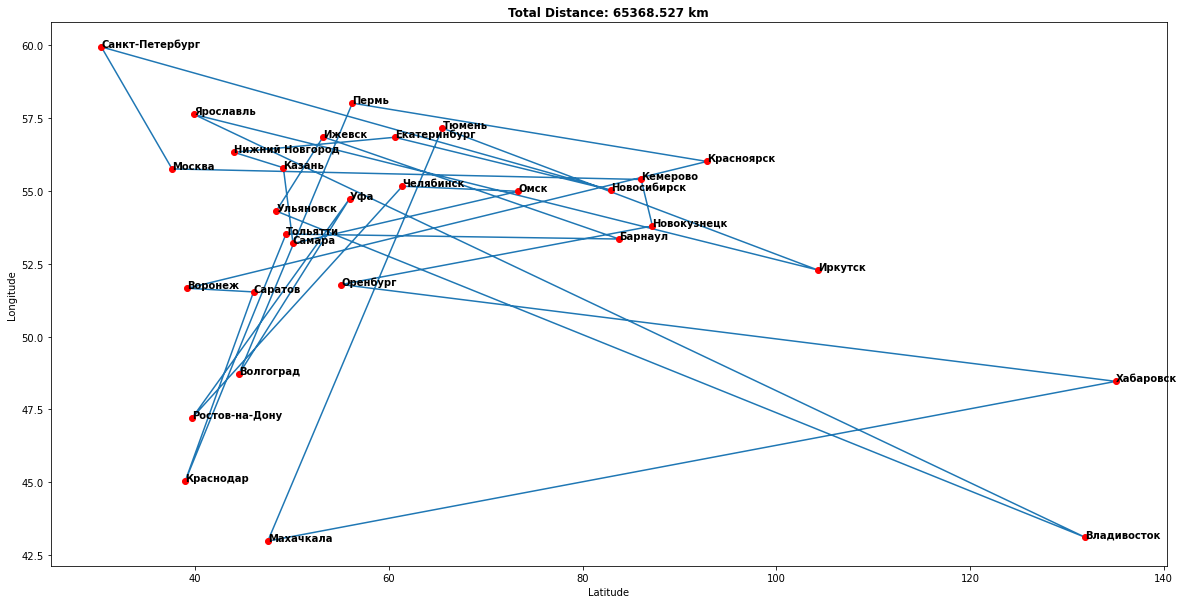

In [4]:
path = Path(data) 
path.plot()

# Simulated annealing implementation

**SimulatedAnnealing** class implements the algorithm. The optimization process is divided into epochs. An epoch represents a fixed value of the annealing temperature. Each epoch samples the fixed number of path samples. The sampling process described in the **Path modification** section. If the current path sample is better than the current best path, the best path is updated, otherwise, the best path is updated with probability:

$$p = e^{\frac{D_{cur} - D_{best}}{T_{i}}}$$

where $D_{cur}$ - is current path sample total distance, $D_{best}$ - is the current best path total distance, $T_i$ - current epoch's temperature

## Path modification

Candidate paths are generated by randomly swapping two cities in the current path. There are other notable approaches to path modification: path segment cut and paste, and path segment reversion. The swapping approach was chosen to speed up calculations since it is easy to apply and easy to reverse - apply swap one more time  

## Annealing schedule

The initial temperature is set to $T = 10000$. The value was obtained experimentally. The value is choosen to be of the same magnitude as the change in the distance after one epoch execution: tens of thousands of kilometers

At the end of each epoch the current annealing temperature is updated with exponential rate decay:

$$T_{i+1} = \alpha T_{i}$$

where $\alpha \in (0, 1)$

## Exit criteria

- An epoch is finished if the maximum samples per epoch were generated or the number of successfully generated path samples is more than a specific number. Success means a path sample was accepted as the new best path
- The annealing process is finished if the limit in the epoch number is reached or the current epoch had no sucessfully generated path samples

In [5]:
class SimulatedAnnealing:
  def __init__(self, T_0: int = 10000, alpha: float = 0.99, n_epochs: int = 1000, max_samples_per_epoch: int = 800, n_successes_for_epoch_end: int = 500):
    self._T = T_0
    self._alpha = alpha
    self._n_epochs = n_epochs
    self._max_samples_per_epoch = max_samples_per_epoch
    self._n_successes_for_epoch_end = n_successes_for_epoch_end

    self._temperatures = []
    self._distances = []

  @property
  def temperatures(self) -> list:
    return self._temperatures

  @property
  def distances(self) -> list:
    return self._distances

  def optimize(self, path) -> None:
    self._temperatures = []
    self._distances = []

    for epoch in range(self._n_epochs):
      n_successes = 0
      self._temperatures.append(self._T)
      self._distances.append(path.distance)

      for sample in range(self._max_samples_per_epoch):
        cur_distance = path.distance

        idxs = np.random.choice(len(path), 2, replace=False)
        path.swap(idxs[0], idxs[1])
        new_distance = path.distance

        if new_distance < cur_distance:
          n_successes += 1
        else:
          p = np.exp((cur_distance - new_distance) / self._T)
          if np.random.uniform() > p:
            path.swap(idxs[0], idxs[1])
          else:
            n_successes += 1

        if n_successes > self._n_successes_for_epoch_end:
          break

      if n_successes == 0:
        return
      self._T *= self._alpha

  def plot(self) -> None:
    plt.figure(figsize=(20, 5))

    plt.subplot(1, 2, 1)
    plt.plot(self.distances)
    plt.title("Best Distance At Step", weight='bold')
    plt.xlabel("Step")
    plt.ylabel("Distance (km)")

    plt.subplot(1, 2, 2)
    plt.plot(self.temperatures)
    plt.title("Temperature Value At Epoch", weight='bold')
    plt.xlabel("Epoch")
    plt.ylabel("Temperature")
    plt.show()


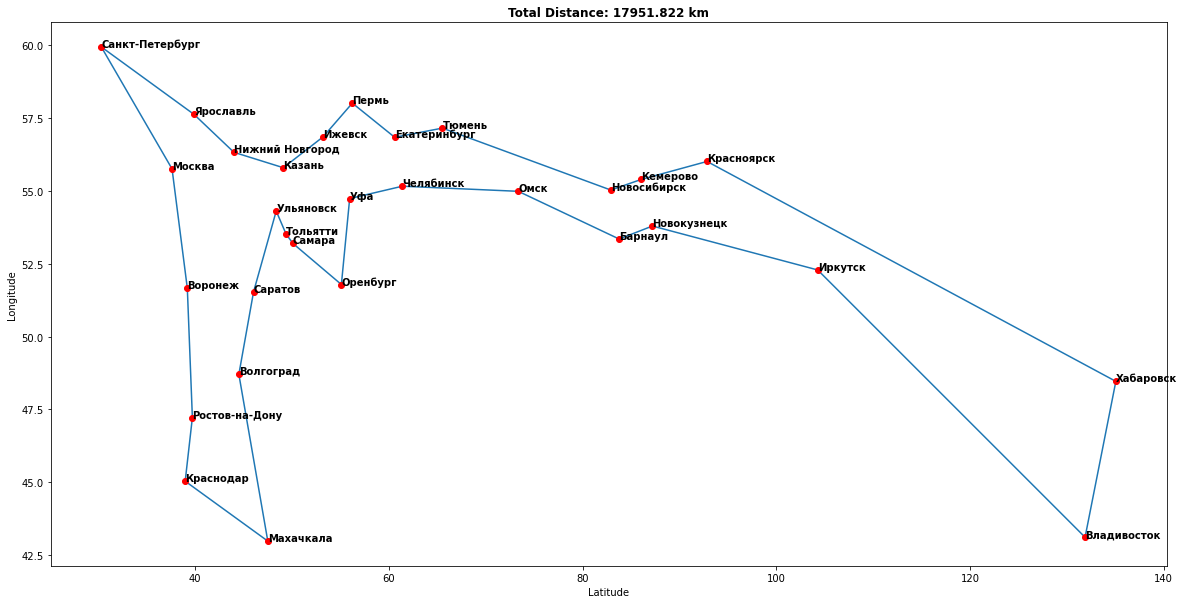

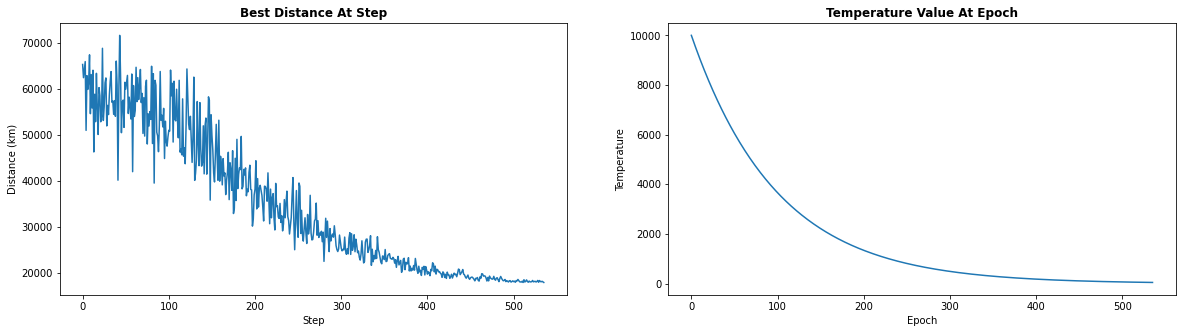

In [6]:
optimizer = SimulatedAnnealing()
path = Path(data)

optimizer.optimize(path)

path.plot()
optimizer.plot()

# Annealing rate selection

Now we test different annealing rates as required in the task: slow cooling, moderate cooling, fast cooling

The most interesting quantities to investigate are execution time and the  total number of epochs, and resultant distance variance and the best distances

Since the annealing process is stochastic, we repeat the annealing process for each alpha multiple times

In [8]:
def alphas_benchmark(data, alphas, N=50, n_epochs=1000):
  optimal_distances = []
  epochs_to_stop = []
  execution_times = []
  for alpha in alphas:
    optimizer = SimulatedAnnealing(alpha=alpha, n_epochs=n_epochs)
    cur_optimal_distances = []
    cur_epochs_to_stop = []
    cur_execution_times = []
    for i in range(N):
      path = Path(data)
      start = time.time()
      optimizer.optimize(path)
      end = time.time()
      cur_optimal_distances.append(path.distance)
      cur_epochs_to_stop.append(len(optimizer.distances))
      cur_execution_times.append(end - start)
    optimal_distances.append(cur_optimal_distances)
    epochs_to_stop.append(cur_epochs_to_stop)
    execution_times.append(cur_execution_times)
  optimal_distances = np.array(optimal_distances).T
  epochs_to_stop = np.array(epochs_to_stop).T
  execution_times = np.array(execution_times).T
  
  best_distances = np.min(optimal_distances, axis=0)
  for alpha, distance in zip(alphas, best_distances):
    print(f"Best distance for {alpha} is: {distance:.3f} km")

  plt.figure(figsize=(15, 8))
  plt.boxplot(optimal_distances, patch_artist=True, boxprops=dict(facecolor="#0eed7e"))
  plt.xticks([i + 1 for i in range(len(alphas))], alphas)
  plt.title(f"Alphas benchmark - best distances. N: {N}. Max Epochs: {n_epochs}")
  plt.xlabel("Alpha values")
  plt.ylabel("Best distances")
  plt.show()

  plt.figure(figsize=(15, 8))
  plt.boxplot(execution_times, patch_artist=True, boxprops=dict(facecolor="#0eed7e"), showfliers=False)
  plt.xticks([i + 1 for i in range(len(alphas))], alphas)
  plt.title(f"Alphas benchmark - execution time. N: {N}. Max Epochs: {n_epochs}")
  plt.xlabel("Alpha values")
  plt.ylabel("Execution time (s)")
  plt.show()

  plt.figure(figsize=(15, 8))
  plt.boxplot(epochs_to_stop, patch_artist=True, boxprops=dict(facecolor="#0eed7e"), showfliers=False)
  plt.xticks([i + 1 for i in range(len(alphas))], alphas)
  plt.title(f"Alphas benchmark - epochs to stop. N: {N}. Max Epochs: {n_epochs}")
  plt.xlabel("Alpha values")
  plt.ylabel("Epochs to stop")
  plt.show()

  return optimal_distances, epochs_to_stop, execution_times

Best distance for 0.1 is: 18379.158 km
Best distance for 0.25 is: 18017.850 km
Best distance for 0.5 is: 18884.624 km
Best distance for 0.75 is: 18338.409 km
Best distance for 0.9 is: 17995.990 km
Best distance for 0.99 is: 17951.822 km
Best distance for 0.995 is: 18130.797 km


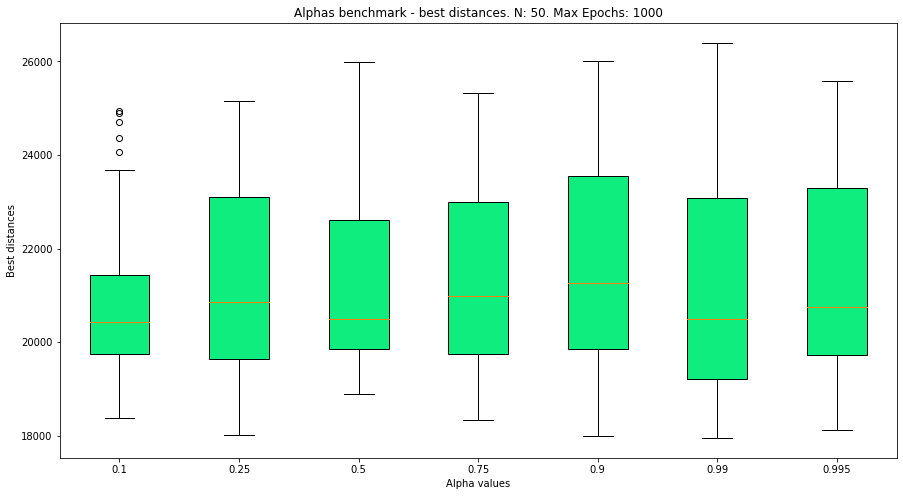

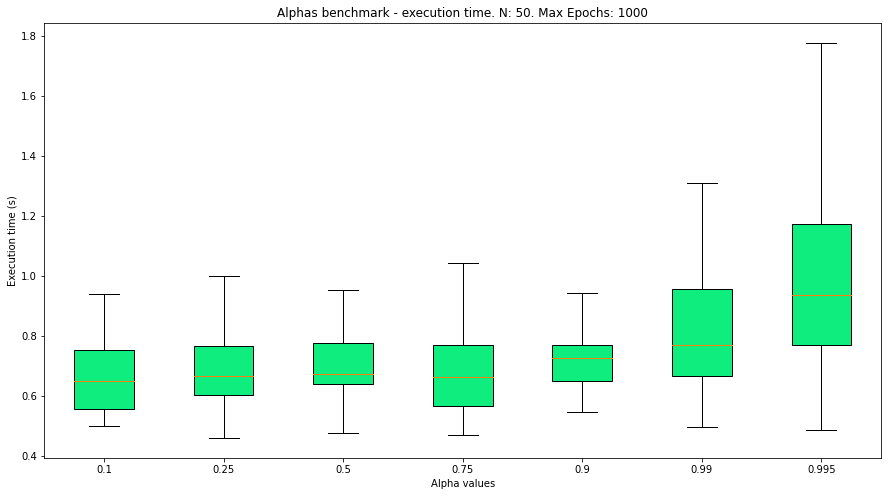

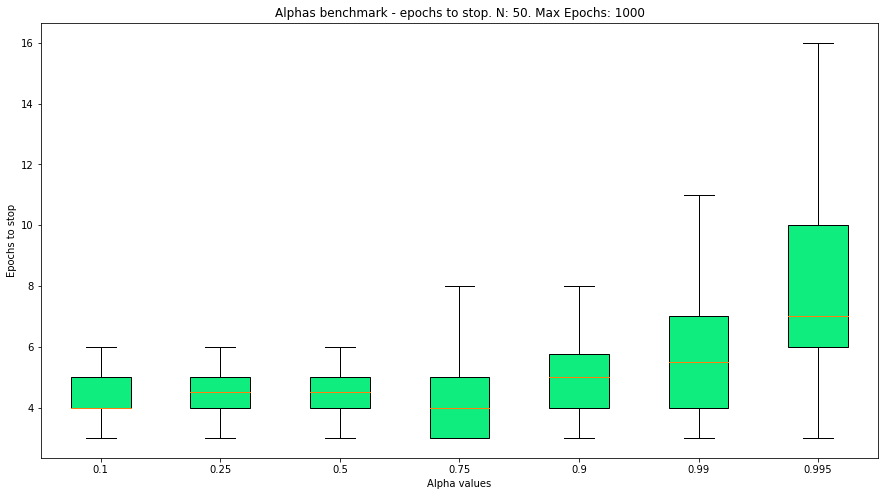

In [9]:
alphas = [0.1, 0.25, 0.5, 0.75, 0.9, 0.99, 0.995]

result = alphas_benchmark(data, alphas)

# Conclusion

As can be seen on the plots, the larger the $\alpha$, the faster the annealing will stop on average

Result variances do not differ significantly, probably due to large number of samples per epoch - up to 800 path samples. Nevertheless, larger annealing rates have smaller lower bound on the best distances and similar execution times compared to lower annealing rates

The conclusion is to use $\alpha \in [0.9, 0.99]$ for this problem